In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-time-series-20050101-to-20171231/CAT_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/UTX_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/PFE_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/PG_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/UNH_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/JNJ_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/VZ_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/AABA_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/BA_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/KO_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/MCD_2006-01-01_to_2018-01-01.csv
/kaggle/input/stock-time-series-20050101-to-20171231/MRK_

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, Dense, Activation, GlobalMaxPool1D, Flatten, Dropout
from keras.layers import LSTM
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.tsa.stattools as sts
from scipy.fftpack import fft
from pandas.plotting import autocorrelation_plot


In [3]:
train=pd.read_csv('/kaggle/input/stock-time-series-20050101-to-20171231/IBM_2006-01-01_to_2018-01-01.csv')
train

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM
...,...,...,...,...,...,...,...
3015,2017-12-22,151.82,153.00,151.50,152.50,2990583,IBM
3016,2017-12-26,152.51,153.86,152.50,152.83,2479017,IBM
3017,2017-12-27,152.95,153.18,152.61,153.13,2149257,IBM
3018,2017-12-28,153.20,154.12,153.20,154.04,2687624,IBM


<AxesSubplot:xlabel='Date'>

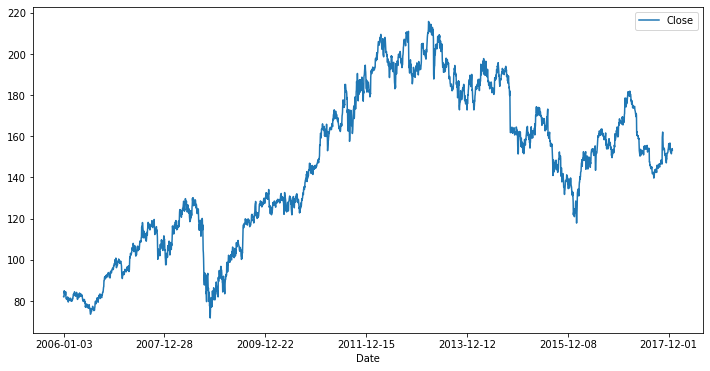

In [4]:
train.filter(items=['Close']).set_index(train['Date']).plot(figsize=(12,6))

In [5]:
#H0: has no stationarity
sts.adfuller(train.Close)
#0.39853584895212746<0.5
#we reject the null hypothesis

(-1.7638801105092734,
 0.39853584895212746,
 10,
 3009,
 {'1%': -3.432525103812134,
  '5%': -2.8625010207824237,
  '10%': -2.5672815764482335},
 12223.051657752378)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

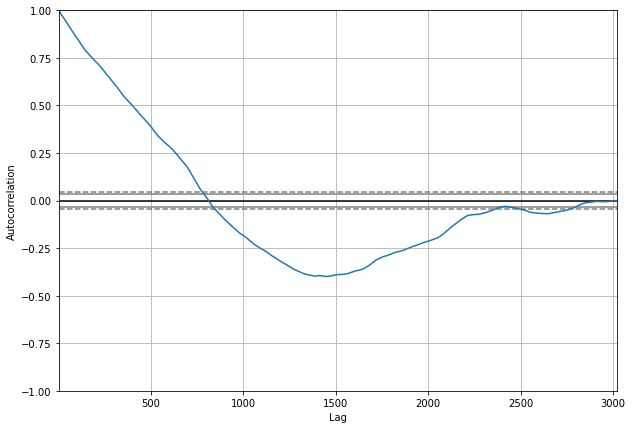

In [6]:
from pandas.plotting import autocorrelation_plot

fig = plt.figure(figsize=(10, 7))
autocorrelation_plot(train.iloc[:,4])

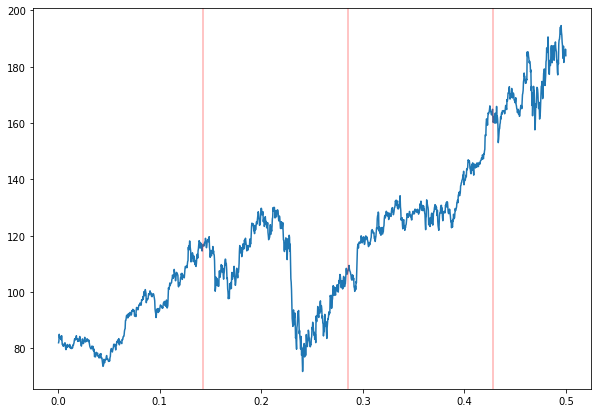

In [7]:
fft_complex = fft(train.filter(items=['Close']))
fft_mag =[np.sqrt(np.real(x)*np.real(x)+np.imag(x)*np.imag(x)) for x in fft_complex]

arr = np.array(fft_mag)
fft_mean = np.mean(arr,axis=1)

fft_xvals = [day / fft_mean.shape[0] for day in range(fft_mean.shape[0])]

npts = len(fft_xvals) // 2 + 1
fft_mean = fft_mean[:npts]
fft_xvals = fft_xvals[:npts]

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(fft_xvals[1:],fft_mean[1:])
plt.axvline(x=1./7,color='red',alpha=0.3)
plt.axvline(x=2./7,color='red',alpha=0.3)
plt.axvline(x=3./7,color='red',alpha=0.3)

In [8]:
train['Close_log']=np.log(train['Close'])

<AxesSubplot:xlabel='Date'>

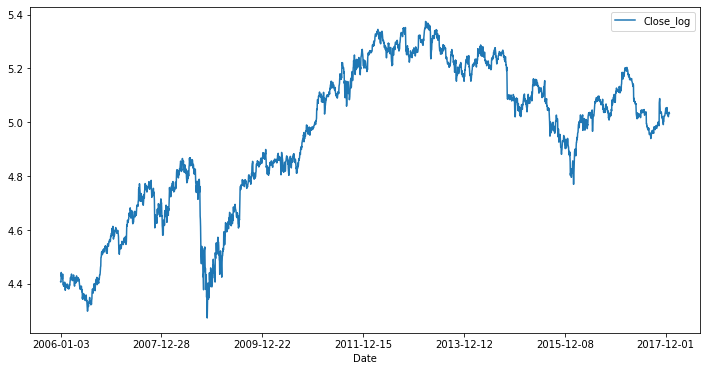

In [9]:
train.filter(items=['Close_log']).set_index(train['Date']).plot(figsize=(12,6))

<AxesSubplot:xlabel='Date'>

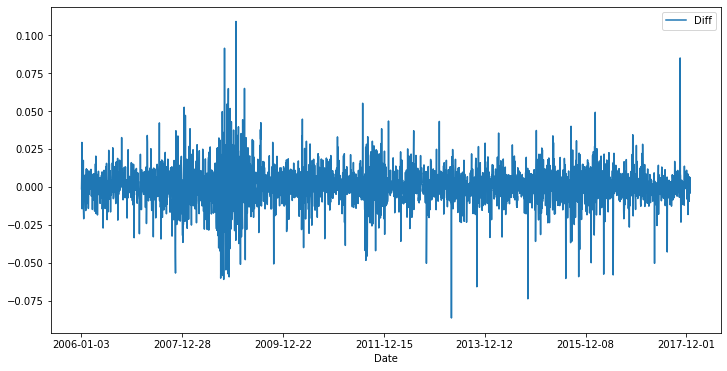

In [10]:
train['Diff'] = train.Close_log - train.Close_log.shift()
train.filter(items=['Diff']).set_index(train['Date']).plot(figsize=(12,6))

In [11]:
sts.adfuller(train.iloc[1:,-1])

(-17.76514538252224,
 3.325598178838363e-30,
 9,
 3009,
 {'1%': -3.432525103812134,
  '5%': -2.8625010207824237,
  '10%': -2.5672815764482335},
 -17238.993735692842)

In [12]:
train.isnull().sum()

Date         0
Open         1
High         0
Low          1
Close        0
Volume       0
Name         0
Close_log    0
Diff         1
dtype: int64

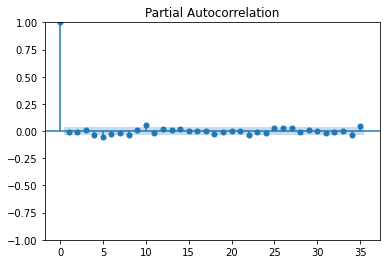

In [13]:
plot_pacf(train.iloc[1:,-1])
plt.show()

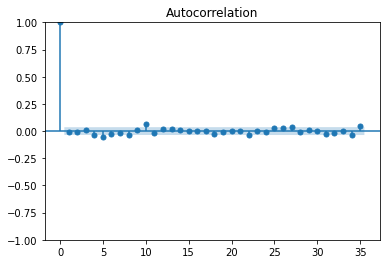

In [14]:
plot_acf(train.iloc[1:,-1])
plt.show()

In [15]:
train

,Date,Open,High,Low,Close,Volume,Name,Close_log,Diff
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM,4.407451,NaN
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM,4.406109,-0.001341
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM,4.412798,0.006689
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM,4.442063,0.029265
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM,4.427597,-0.014466
...,...,...,...,...,...,...,...,...,...
3015,2017-12-22,151.82,153.00,151.50,152.50,2990583,IBM,5.027165,0.006579
3016,2017-12-26,152.51,153.86,152.50,152.83,2479017,IBM,5.029326,0.002162
3017,2017-12-27,152.95,153.18,152.61,153.13,2149257,IBM,5.031287,0.001961
3018,2017-12-28,153.20,154.12,153.20,154.04,2687624,IBM,5.037212,0.005925


In [16]:
X = train.iloc[1:50,-1]
y = train.iloc[51:100,-1]
X_train, X_val, y_train, y_val =train_test_split(X.values, y.values,test_size=0.1, random_state=42)

In [17]:
model = ARIMA(X_train, order=(1,0,1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   44
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 143.743
Date:                Mon, 23 Jan 2023   AIC                           -279.486
Time:                        05:12:11   BIC                           -272.349
Sample:                             0   HQIC                          -276.839
                                 - 44                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.691e-05      0.001     -0.013      0.990      -0.003       0.003
ar.L1          0.3502      2.159      0.162      0.871      -3.882       4.582
ma.L1         -0.4305      2.076     -0.207      0.836      -4.499       3.637
sigma2      8.499e-05   1.71e-05      4.959      0.000    5.14e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 2.10
Prob(Q):                              0.59   Prob(JB):                         0.35
Heteroskedasticity (H):               1.61   Skew:                             0.27
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

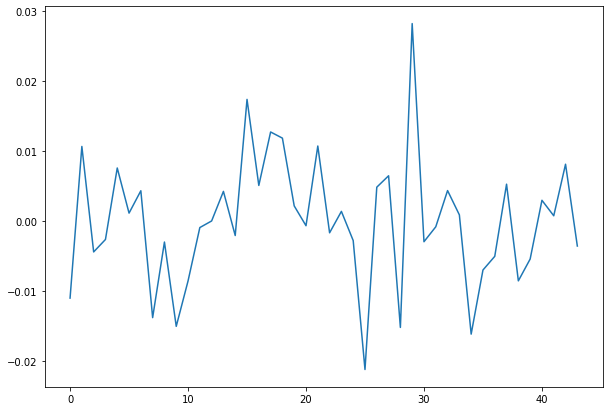

In [18]:
fig, ax = plt.subplots(figsize=(10, 7))
residuals = pd.DataFrame(model.resid)
ax.plot(residuals)

<AxesSubplot:ylabel='Density'>

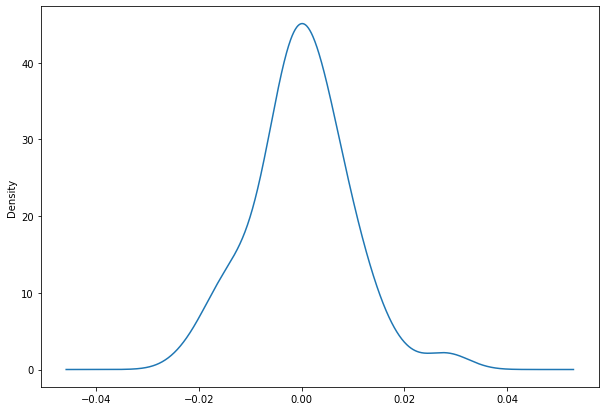

In [19]:
residuals.plot(kind='kde',figsize=(10,7),legend = False)

In [20]:
predictions = model.forecast(50,alpha=0.05)

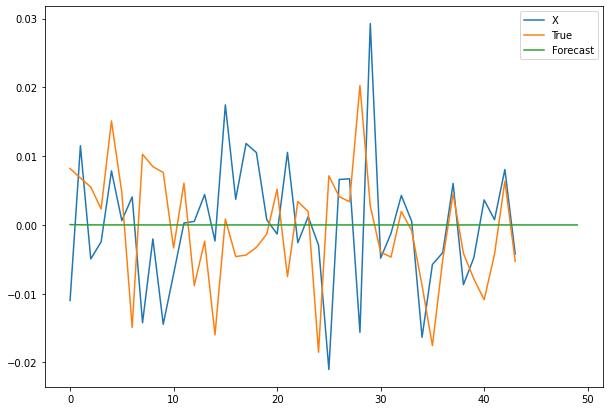

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))


ax.plot(X_train, label='X')
ax.plot(y_train,label='True')

ax.plot(predictions,label='Forecast')

ax.legend()
#ax.set_yscale('log')